# Transcription factor activity inference

scRNA-seq yield many molecular readouts that are hard to interpret by themselves. One way of summarizing this information is by infering transcription factor (TF) activities from prior knowledge.

In this notebook we showcase how to use `decoupler` for TF activity inference with the 3k PBMCs 10X data-set. The data consists of 3k PBMCs from a Healthy Donor and is freely available
from 10x Genomics [here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz)
from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)

<div class="alert alert-info">

**Note**
    
This tutorial assumes that you already know the basics of `decoupler`. Else, check out the [Usage](https://decoupler-py.readthedocs.io/en/latest/notebooks/usage.html) tutorial first.

</div>

## Loading packages

First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data
and `decoupler` to use statistical methods.

In [1]:
import scanpy as sc
import decoupler as dc

# Only needed for visualization:
import matplotlib.pyplot as plt
import seaborn as sns

## Loading the data

We can download the data easily using `scanpy`:

In [2]:
adata = sc.datasets.pbmc3k_processed()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

We can visualize the different cell types in it:

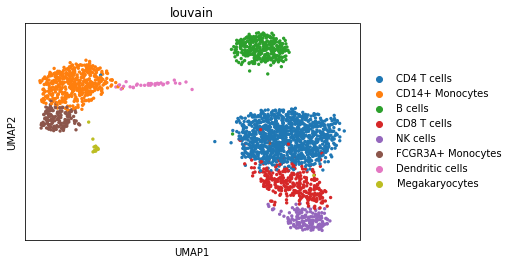

In [3]:
sc.pl.umap(adata, color='louvain')

## DoRothEA network

[DoRothEA](https://saezlab.github.io/dorothea/) is a comprehensive resource containing a curated collection of TFs and their transcriptional targets. Since these regulons were gathered from different types of evidence, interactions in DoRothEA are classified in different confidence levels, ranging from A (highest confidence) to D (lowest confidence). Moreover, each interaction is weighted by its confidence level and the sign of its mode of regulation (activation or inhibition).

For this example we will use the human version (other organisms are available) and we will use the confidence levels ABC. To access it we can use `decoupler`.

In [4]:
net = dc.get_dorothea(organism='human', levels=['A','B','C'])
net

,source,confidence,target,weight
0,ETS1,A,IL12B,1.000000
1,RELA,A,IL6,1.000000
2,MITF,A,BCL2A1,-1.000000
3,E2F1,A,TRERF1,1.000000
4,MITF,A,BCL2,1.000000
...,...,...,...,...
32272,IKZF1,C,PTK2B,0.333333
32273,IKZF1,C,PRKCB,0.333333
32274,IKZF1,C,PREX1,0.333333
32275,IRF4,C,SLAMF7,0.333333


## Activity inference with Multivariate Linear Model

To infer activities we will run the Multivariate Linear Model method (`mlm`). It models the observed gene expression by using a regulatory adjacency matrix (target genes x TFs) as covariates of a linear model. The values of this matrix are the associated interaction weights.
The obtained t-values of the fitted model are the activity scores.

To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge
network/resource (`net`), and the name of the columns of `net` that we want to use.

In [5]:
dc.run_mlm(mat=adata, net=net, source='source', target='target', weight='weight', verbose=True)

1 features of mat are empty, they will be removed.
Running mlm on mat with 2638 samples and 13713 targets for 281 sources.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.78s/it]


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [6]:
adata.obsm['mlm_estimate']

,AHR,AR,ARID2,ARID3A,ARNT,ARNTL,ASCL1,ATF1,ATF2,ATF3,...,ZNF217,ZNF24,ZNF263,ZNF274,ZNF384,ZNF584,ZNF592,ZNF639,ZNF644,ZNF740
AAACATACAACCAC-1,1.378355,2.274427,-0.874242,-0.387186,0.148249,-0.675334,-0.517506,-0.244091,3.509188,2.846779,...,0.186219,-0.365014,-2.079993,-0.819782,-1.074077,-0.510540,-0.165862,1.016863,-0.426996,0.328519
AAACATTGAGCTAC-1,-0.777049,1.804605,-0.846151,-2.420458,1.131415,-1.712532,-0.096642,-0.433711,1.155111,0.332896,...,0.976601,-1.012220,-1.297776,-0.695343,-0.721801,-0.848833,-0.629448,-0.015790,0.189198,0.088182
AAACATTGATCAGC-1,1.697553,3.003373,-0.532198,-1.707768,0.860097,-1.167976,-0.792977,1.835434,3.586673,2.078914,...,0.011449,-0.423068,-2.063008,-0.533873,-0.761211,0.064575,0.296225,1.087730,1.092369,1.271436
AAACCGTGCTTCCG-1,0.955585,2.368041,-0.058802,-2.913917,0.934386,-1.021379,-0.009797,0.163788,2.798030,0.091727,...,0.738507,-0.743231,-1.333049,-1.056086,-1.692437,-0.824906,-0.641627,-0.136234,-0.631287,-0.588915
AAACCGTGTATGCG-1,1.067031,1.692220,-0.635391,-1.558621,0.028015,-1.936304,-0.378153,-1.907514,-2.097300,2.618122,...,1.405655,-0.784626,-1.912015,0.277506,-0.626883,-0.592061,0.778218,0.930766,-0.350260,0.224808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCGAACTCTCAT-1,0.318478,3.343055,-0.411779,-1.802754,-0.014591,-1.429359,-0.362832,-0.070588,1.551657,-1.498392,...,0.928078,0.173974,-1.504168,-1.249793,-0.711441,-0.818099,-0.448721,-0.257337,0.460690,-0.117471
TTTCTACTGAGGCA-1,0.033183,3.501705,-0.000555,-1.534433,1.561845,-1.666364,-0.373773,0.738644,2.446522,-0.298816,...,0.809919,-0.533287,-1.729188,-0.584088,-1.228989,-1.447585,0.498228,1.190310,-0.315665,-0.154943
TTTCTACTTCCTCG-1,0.830120,1.227889,-0.081503,-2.478240,1.034375,-1.065700,-0.542246,0.113498,4.678612,0.359061,...,0.061982,-0.709467,-0.495299,-0.122368,0.295769,-0.587837,-0.334145,-0.498106,-0.106478,0.140377
TTTGCATGAGAGGC-1,1.640406,-1.019982,-0.213989,-1.342614,-1.092845,-1.062122,-0.474243,-1.477003,3.468400,-0.166772,...,0.090998,-0.551890,-1.831205,-0.717355,-1.362649,0.784528,-0.567212,1.206249,-0.513655,-0.483068


**Note**: Each run of `run_mlm` overwrites what is inside of `mlm_estimate` and `mlm_pvals`. if you want to run `mlm` with other resources and still keep the activities inside the same `AnnData` object, you can store the results in any other key in `.obsm` with different names, for example:

In [7]:
adata.obsm['dorothea_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['dorothea_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

## Visualization

To visualize the obtained scores, we can re-use many of `scanpy`'s plotting functions.
First though, we need to extract them from the `adata` object.

In [8]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

AnnData object with n_obs × n_vars = 2638 × 281
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr', 'mlm_estimate', 'mlm_pvals', 'dorothea_mlm_estimate', 'dorothea_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its `.X` attribute, allowing us to re-use many `scanpy` functions, for example:

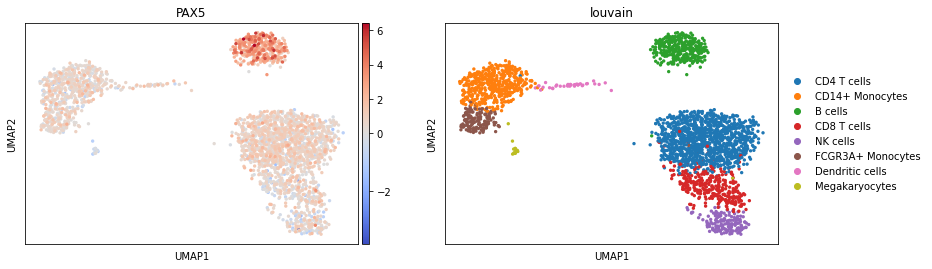

In [9]:
sc.pl.umap(acts, color=['PAX5', 'louvain'], cmap='coolwarm', vcenter=0)

Here we observe the activity infered for PAX5 across cells, which it is particulary active in B cells. Interestingly, PAX5 is a known TF crucial for B cell identity and function.
The inference of activities from "foot-prints" of target genes is more informative than just looking at the molecular readouts of a given TF, as an example here is the gene expression of PAX5, which is not very informative by itself:

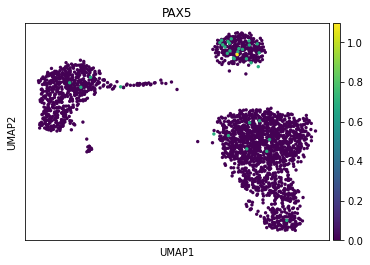

In [10]:
sc.pl.umap(adata, color='PAX5')

## Exploration

With `decoupler` we can also see what is the mean activity per group (to show more TFs, increase the `min_std` parameter):

In [11]:
mean_acts = dc.summarize_acts(acts, groupby='louvain', min_std=0.75)
mean_acts

,ATF2,ATF3,BACH2,CEBPB,CREB1,CREM,E2F7,ELK1,ESR2,FLI1,...,REL,RFX5,SPI1,SRF,STAT3,STAT4,TWIST1,USF2,VDR,ZEB2
B cells,2.868587,0.022602,1.464726,-1.234619,0.767511,-1.476407,2.415689,2.066459,3.021957,-1.223385,...,-0.240303,13.696566,1.991853,1.016835,0.459040,-0.632491,-0.404400,1.144343,3.564371,1.000175
CD14+ Monocytes,2.007714,0.175447,2.859986,0.866449,-1.072762,-1.804330,3.222964,1.711882,5.142670,-0.796957,...,-0.485268,6.818030,3.603954,2.031029,1.407858,2.494360,-0.855818,0.471007,3.636787,2.269021
CD4 T cells,2.811583,0.879623,1.298020,-1.463941,-0.925841,-1.807085,2.640772,2.972541,3.769373,-0.997432,...,-0.050020,1.309786,1.484332,1.357391,1.239065,0.394266,-0.115241,1.138940,3.678631,1.265142
CD8 T cells,1.989253,2.657882,1.488735,-1.821871,-0.215796,-1.692385,2.414712,2.496823,4.036488,-0.926765,...,1.185035,2.524118,2.053695,1.825817,0.574987,1.715534,-0.182004,1.357577,3.518316,0.995989
Dendritic cells,2.875063,0.184359,1.892848,-0.751902,-0.419758,-1.445644,3.163058,1.887027,3.739679,-0.930901,...,0.011379,15.106863,3.594913,2.652861,1.206054,1.013332,-0.983827,0.482137,4.096582,2.625957
FCGR3A+ Monocytes,2.303873,0.451908,2.498814,-0.921232,-1.259868,-1.750411,3.196807,1.929357,4.906310,-0.540120,...,-0.815608,7.600002,4.006298,2.647358,2.224453,2.496363,-1.937861,0.902676,3.707245,1.954463
Megakaryocytes,0.050993,2.751533,4.110503,-2.296985,0.882954,0.872765,0.667223,-0.532625,5.092278,2.361103,...,2.617590,2.172133,3.807284,7.223926,-1.168846,-1.041995,-2.491852,3.492409,1.438276,0.944554
NK cells,1.114531,2.093307,1.790295,-1.819632,-0.830680,-2.286488,2.121871,1.579840,4.136767,-1.014884,...,-0.037481,2.075289,2.802213,2.380026,0.256690,3.383240,-0.715219,1.481768,3.433856,0.419311


We can visualize which TF is more active across cell types using `seaborn`:

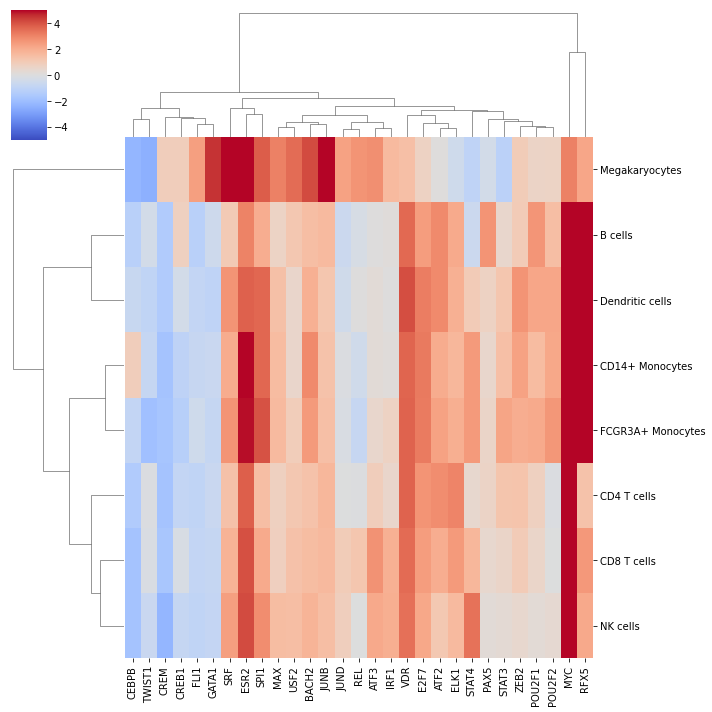

In [12]:
sns.clustermap(mean_acts, xticklabels=mean_acts.columns, vmin=-5, vmax=5, cmap='coolwarm')
plt.show()

Here we can observe other known marker TFs appering, GATA1 for megakaryocytes, RFX5 for the myeloid lineage and JUND for the lymphoid.

<div class="alert alert-info">

**Note**
    
If your data consist of different conditions with enough samples, we recommend to work with pseudo-bulk profiles instead. Check this
[vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more informatin.

</div>